In [1]:
# This notebook was adapted from the notebook used in the specialization in Reinforcement Learning 
# from Alberta University, available in Coursera

import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
import numpy as np
import random as rand

from RL.agents import DynaQPlusAgent
from RL.environments import SimulatedEnv

In [2]:
os.makedirs('results', exist_ok=True)
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

# 1. Dyna-Q in Static Environment

In [3]:

def run_experiment(EnvClass, AgentClass, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = dict(agent_parameters)

    # for collecting metrics that shall be plotted later
    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes))  
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):
        print('Planning steps : ', planning_steps)
        sleep(1.0)  # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):
            rand.seed(i)

            # instantiate environment and agent
            env = EnvClass(**env_info)
            agent = AgentClass(**agent_info)

            agent.start_train(env)

            for j in range(num_episodes):
                is_terminal = False
                num_steps = 0
                while not is_terminal:
                    _, _, _, is_terminal = agent.step_train()
                    num_steps += 1

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    np.save("results/Dyna-Q_planning_steps", log_data)
    

def plot_steps_per_episode(file_path):
    data = np.load(file_path, allow_pickle=True).item()
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    all_averages = np.mean(all_averages, axis=1)
    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(all_averages[i], label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

In [4]:

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,             # The number of times we run the experiment
    "num_episodes" : 40,         # The number of episodes per experiment
}

# Environment parameters 
env_parameters = {
    "count_visits" : False,
    "reward_option" : 'step_cost'
}

# Agent parameters
agent_parameters = {  
    "gamma": 0.95,
    "epsilon": 0.1, 
    "alpha" : 0.5, #0.125,                  # Also called "step size"; similar to a learning rate
    "planning_steps" : [0, 5, 50],    # The list of planning_steps we want to try
    "kappa" : 0.0,                    # To behave as Dyna-Q
    "model_option" : 'state+next_state+actions'
}

current_env = SimulatedEnv      # The environment
current_agent = DynaQPlusAgent  # The agent

run_experiment(current_env, current_agent, env_parameters, agent_parameters, experiment_parameters)

Planning steps :  0
100%|██████████| 30/30 [00:02<00:00, 11.80it/s]
Planning steps :  5
100%|██████████| 30/30 [00:02<00:00, 12.76it/s]
Planning steps :  50
100%|██████████| 30/30 [00:08<00:00,  3.42it/s]


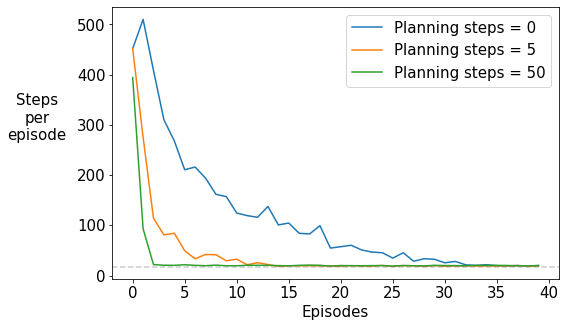

In [5]:
plot_steps_per_episode('results/Dyna-Q_planning_steps.npy')

# 2. Dyna-Q in Dynamic Environment

## 2.1 Experiment with Varying Planning Steps

In [6]:
# represents as an int, using only the position (discards the direction)
def int_repr(env, state):
    row, col, d = state
    assert row >= 0 and col >= 0
    return row * len(env.map[0]) + col

In [7]:
def change_environment(env):
    #env.map[2][0] = 1   # closes a corridor in the start of row 2
    env.map[2][-1] = 0  # opens another one on the other end of the row

env = SimulatedEnv()
#print(env.map)
change_environment(env)
print(env.map)

[[0, 0, 0, 0, 0, 0, 2], [0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 0, 0]]


In [8]:

def run_experiment_with_state_visitations(EnvClass, AgentClass, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    #env_info = dict(env_parameters)
    agent_info = dict(agent_parameters)

    env = EnvClass()
    num_positions = len(env.map) * len(env.map[0])

    # For saving the number of state-visitations
    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, num_positions))  
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, num_positions)) 
    # For saving the cumulative reward
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))

    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        sleep(1.0)  # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):
            rand.seed(run)

            # instantiate environment and agent
            env = EnvClass(**env_parameters)
            agent = AgentClass(**agent_info)

            agent.start_train(env)

            num_steps = 0
            cum_reward = 0

            # the condition on "num_steps" here must be the same as in the inner loop
            # removing "-1" only here causes infinite loop
            while num_steps < num_max_steps-1 :
                # this is the initial state of an episode (not returned by train_step)
                state = int_repr(env, agent.reset_env())
                # We'll be collecting the state-visitation counts to visiualize the learned policy
                is_terminal = False
                if num_steps < exp_parameters['change_at_n']: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    a, r, state, is_terminal = agent.step_train()
                    
                    state = int_repr(env, state)
                    num_steps += 1
                    # change the environment
                    if (num_steps == exp_parameters['change_at_n']):
                        change_environment(agent.env)
                    
                    cum_reward += r
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < exp_parameters['change_at_n']:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/" + result_file_name, log_data)

def plot_cumulative_reward(file_path, item_key, y_key, y_axis_label, legend_prefix, title, vert_line_pos):
    data_all = np.load(file_path, allow_pickle=True).item()
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=vert_line_pos, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

In [9]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 10,                   # The number of times we run the experiment
    "num_max_steps" : 10000,           # The number of steps per experiment
    "change_at_n" : 5000
}

# Environment parameters
environment_parameters = { 
    "count_visits" : False,
    "use_real_state" : True,
    "reward_option" : 'step_cost'
}

# Agent parameters
agent_parameters = {  
    "epsilon": 0.1, 
    "gamma": 0.95,
    "alpha" : 0.5, #optuna: 0.65,
    "kappa" : 0.0,
    "planning_steps" : [5, 10, 50],             # The list of planning_steps we want to try
    "model_option" : 'state+next_state+actions' # With 'all' or 'state+actions': parallel graphs
}

current_env = SimulatedEnv          # The environment
current_agent = DynaQPlusAgent      # The agent

run_experiment_with_state_visitations(
    current_env, current_agent, 
    environment_parameters, agent_parameters, experiment_parameters, 
    "Dyna-Q_shortcut_steps")

Planning steps :  5
100%|██████████| 10/10 [00:06<00:00,  1.59it/s]
Planning steps :  10
100%|██████████| 10/10 [00:10<00:00,  1.03s/it]
Planning steps :  50
100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


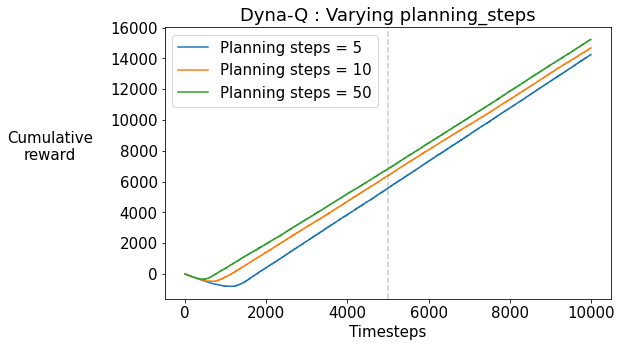

In [10]:
plot_cumulative_reward('results/Dyna-Q_shortcut_steps.npy', 
    'planning_steps_all', 
    'cum_reward_all', 
    'Cumulative\nreward', 
    'Planning steps = ', 
    'Dyna-Q : Varying planning_steps',
    experiment_parameters["change_at_n"])

In [11]:
def plot_state_visitations(file_path, plot_titles, idx, shape_env):
    data = np.load(file_path, allow_pickle=True).item()
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i, key in enumerate(data_keys):
        state_visits = data[key][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape(shape_env).T)
        #grid_state_visits[2,1:wall_ends[i]] = np.nan # walls
        #print(average_state_visits.reshape((6,9)))
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(6+0.5, 4+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()

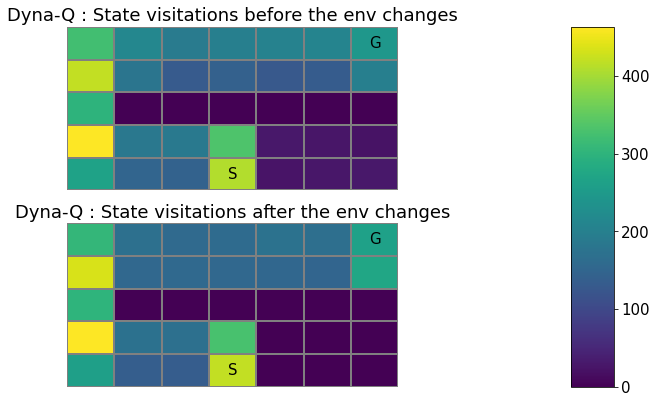

In [12]:
env = SimulatedEnv()
shape_env = (len(env.map), len(env.map[0]))
plot_state_visitations("results/Dyna-Q_shortcut_steps.npy", ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 2, shape_env) # index 2 is Dyna-Q with 50 planning steps


## 2.2 Experiment with Varying Epsilons

In [13]:
def run_experiment_only_cumulative_reward(EnvClass, AgentClass, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    epsilons = agent_parameters['epsilon']

    agent_info = dict(agent_parameters)

    log_data = {'epsilons' : epsilons} 
    cum_reward_all = np.zeros((len(epsilons), num_runs, num_max_steps))

    for eps_idx, epsilon in enumerate(epsilons):

        print('Agent : Dyna-Q, epsilon : %f' % epsilon)
        sleep(1.0)  # to prevent tqdm printing out-of-order before the above print()
        agent_info["epsilon"] = epsilon

        for run in tqdm(range(num_runs)):
            rand.seed(run)

            env = EnvClass(**env_parameters)
            agent = AgentClass(**agent_info)

            agent.start_train(env)

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :
                is_terminal = False

                while not is_terminal and num_steps < num_max_steps-1 :
                    a, reward, s, is_terminal = agent.step_train()
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[eps_idx][run][num_steps] = cum_reward

    log_data['cum_reward_all'] = cum_reward_all
    np.save("results/Dyna-Q_epsilons", log_data)

In [14]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,           # The number of times we run the experiment
    "num_max_steps" : 10000,   # The number of steps per experiment
    "change_at_n": 5000
}

# Environment parameters
environment_parameters = { 
    "count_visits" : False,
    "use_real_state" : True,
    "reward_option" : 'step_cost'
}

# Agent parameters
agent_parameters = {  
    "alpha" : 0.5, # 0.125,
    "gamma": 0.95,
    "planning_steps" : 10,
    "kappa" : 0.0,
    "epsilon": [0.1, 0.2, 0.4, 0.8],   # The list of epsilons we want to try
    "model_option" : 'state+next_state+actions'
}

current_env = SimulatedEnv          # The environment
current_agent = DynaQPlusAgent      # The agent

run_experiment_only_cumulative_reward(
    current_env, current_agent, 
    environment_parameters, agent_parameters, experiment_parameters)

Agent : Dyna-Q, epsilon : 0.100000
100%|██████████| 30/30 [00:33<00:00,  1.11s/it]
Agent : Dyna-Q, epsilon : 0.200000
100%|██████████| 30/30 [00:30<00:00,  1.01s/it]
Agent : Dyna-Q, epsilon : 0.400000
100%|██████████| 30/30 [00:31<00:00,  1.05s/it]
Agent : Dyna-Q, epsilon : 0.800000
100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


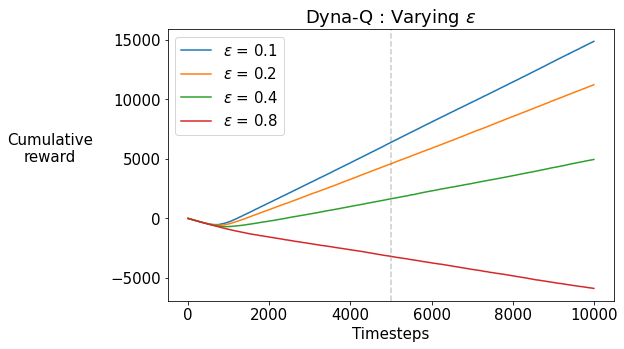

In [15]:
plot_cumulative_reward(
    'results/Dyna-Q_epsilons.npy', 'epsilons', 'cum_reward_all', 
    'Cumulative\nreward', r'$\epsilon$ = ', r'Dyna-Q : Varying $\epsilon$', 
    vert_line_pos=experiment_parameters["change_at_n"])

# 3. Dyna-Q+ in Dynamic Environment

In [16]:
# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 10000,             # The number of steps per experiment
    "change_at_n": 5000
}

# Environment parameters
environment_parameters = { 
    "count_visits" : False,
    "use_real_state" : True,
    "reward_option" : 'step_cost'
}

# Agent parameters
agent_parameters = {  
    "gamma": 0.95,
    "epsilon": 0.1, 
    # parametrizacao 1 -- obtida com o Optuna em ambiente estatico (com 'step_cost')
    "alpha" : 0.9,
    "planning_steps" : [50], # o valor original era 70
    "kappa" : 0.025, # melhor: 0.025 / bom: 0.030; 0.050 pior na 1a parte / optuna: 0.008
    "model_option" : 'state+actions' 
}

current_env = SimulatedEnv          # The environment
current_agent = DynaQPlusAgent      # The agent

run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")  

Planning steps :  50
100%|██████████| 30/30 [01:56<00:00,  3.89s/it]


In [17]:
def plot_cumulative_reward_comparison(file_name_dynaq, file_name_dynaqplus, vertical_line_pos, plan_steps):
    # gets and plots the results of DynaQ with 50 steps
    cum_reward_q = np.load(file_name_dynaq, allow_pickle=True).item()['cum_reward_all'][2] 
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q (50 steps)')
    
    # gets and plots the results of DynaQ+ with the given steps
    data_dynaq_plus = np.load(file_name_dynaqplus, allow_pickle=True).item()

    for i, k in enumerate(plan_steps):
        cum_reward_qPlus = data_dynaq_plus['cum_reward_all'][i]
        plt.plot(np.mean(cum_reward_qPlus, axis=0), label=f'Dyna-Q+ ({k} steps)')

    plt.axvline(x=vertical_line_pos, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Dynamic Env\n')
    plt.show()

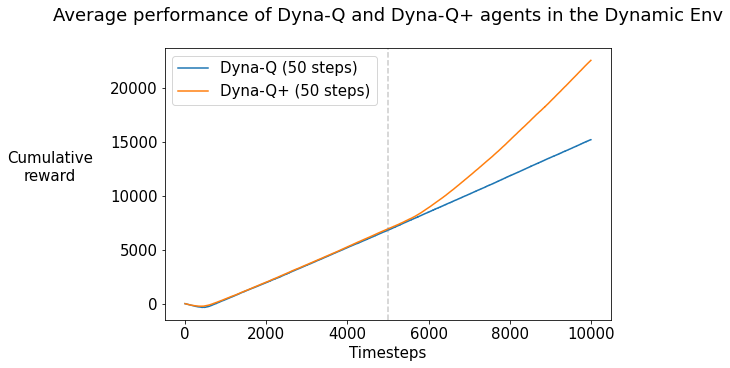

In [18]:
plot_cumulative_reward_comparison(
    'results/Dyna-Q_shortcut_steps.npy', 
    'results/Dyna-Q+.npy', 
    experiment_parameters['change_at_n'], 
    agent_parameters['planning_steps'])

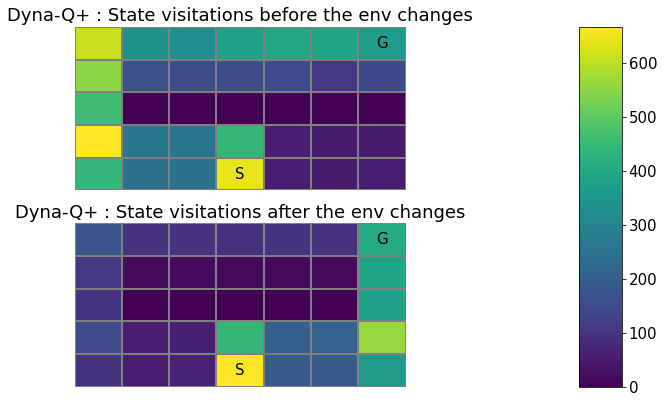

In [19]:
plot_state_visitations(
    'results/Dyna-Q+.npy', 
    ['Dyna-Q+ : State visitations before the env changes', 
    'Dyna-Q+ : State visitations after the env changes'], 
    len(agent_parameters['planning_steps'])-1,   # last index: DynaQ+ with the most steps
    shape_env)  